# Buisness problem

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore")

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Project Objectives**

Provider Fraud is one of the biggest problems facing Medicare. According to the government, the total Medicare spending increased exponentially due to frauds in Medicare claims. Healthcare fraud is an organized crime which involves peers of providers, physicians, beneficiaries acting together to make fraud claims.

Rigorous analysis of Medicare data has yielded many physicians who indulge in fraud. They adopt ways in which an ambiguous diagnosis code is used to adopt costliest procedures and drugs. Insurance companies are the most vulnerable institutions impacted due to these bad practices. Due to this reason, insurance companies increased their insurance premiums and as result healthcare is becoming costly matter day by day.


**Types of frauds**

Healthcare fraud and abuse take many forms. Some of the most common types of frauds by providers are:

a) Billing for services that were not provided.

b) Duplicate submission of a claim for the same service.

c) Misrepresenting the service provided.

d) Charging for a more complex or expensive service than was actually provided.

e) Billing for a covered service when the service actually provided was not covered.


**Objective**

The goal of this project is to " predict the potentially fraudulent providers " based on the claims filed by them.along with this, we will also discover important variables helpful in detecting the behaviour of potentially fraud providers. further, we will study fraudulent patterns in the provider's claims to understand the future behaviour of providers.


**Data we will be working with**

For the purpose of this project, we are considering Inpatient claims, Outpatient claims and Beneficiary details of each provider. Lets s see their details :

A) Inpatient Data

This data provides insights about the claims filed for those patients who are admitted in the hospitals. It also provides additional details like their admission and discharge dates and admit d diagnosis code.

B) Outpatient Data

This data provides details about the claims filed for those patients who visit hospitals and not admitted in it.

C) Beneficiary Details Data

This data contains beneficiary KYC details like health conditions,regioregion they belong to etc.

D)Train Data:

Data containing provider id's and whether they are fraud or not.



**Approach**:

We are given with no details about the health care provider except for the *provider id*. But in inpatient and out paient files we have *provider id* as feature. So we can leverage that and generate information about the provider based on the details of patients.

In [3]:
#importing dependencies
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import random

In [47]:
ben_data=pd.read_csv('/content/drive/MyDrive/Train_Beneficiarydata-1542865627584.csv')
inp_data=pd.read_csv('/content/drive/MyDrive/Train_Inpatientdata-1542865627584.csv')
out_data=pd.read_csv('/content/drive/MyDrive/Train_Outpatientdata-1542865627584.csv')
train_data=pd.read_csv('/content/drive/MyDrive/Train-1542865627584.csv')

##EDA

**Train data**

In [48]:
def bar_plot(x,y,xlab=None,ylab=None,title=None,annotate=False):
  '''This function generates an annotated barplot'''
  fig,ax=plt.subplots(figsize=(8,6))
  custom_palette=['dark:salmon_r','ocean','inferno','BrBG','binary','winter']
  choice=random.choice(custom_palette)
  if title is not None:
    ax.set_title(title)
  else:
    ax.set_title('No title')  
  sns.barplot(x=x,
            y=y,palette=choice,alpha=0.8,edgecolor='black',linewidth=2)
  ax.patch.set_edgecolor('black')  
  ax.patch.set_linewidth('2')
  plt.xlabel(xlab)
  plt.ylabel(ylab)
  if annotate==True:
    for p in ax.patches:
      ax.annotate(p.get_height(), (p.get_x()+p.get_width()/3. * 1.005, p.get_height() * .5))
  plt.show()    

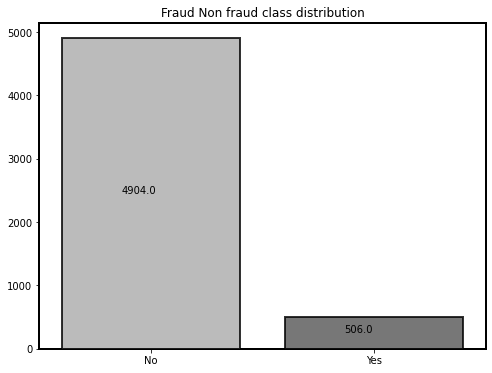

Only 9.35% of healthcare providers are fraudulent 


In [49]:
bar_plot(train_data.PotentialFraud.value_counts().index,train_data.PotentialFraud.value_counts().values,title='Fraud Non fraud class distribution',annotate=True)
plt.show()
print('Only {0:.2f}% of healthcare providers are fraudulent '.format(train_data.PotentialFraud.value_counts()[1]/5410*100))

From above plot we observe that there is a severe class imbalance.

**Inp data**

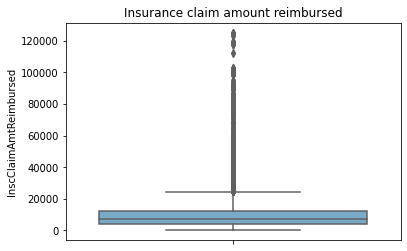

In [50]:
#Insurance claim reimbursed
plt.title('Insurance claim amount reimbursed')
sns.boxplot(y=inp_data.InscClaimAmtReimbursed,palette='Blues')
plt.show()

We see a large amount of outliers in this data.Most patients seem to have humble claim amounts while some having huge claims.

In [51]:
#Physician data
print('Missing values in attending physician',inp_data.AttendingPhysician.isnull().sum())
print('Missing values in operating physician',inp_data.OperatingPhysician.isnull().sum())
print('Missing values in other physician',inp_data.OtherPhysician.isnull().sum())

Missing values in attending physician 112
Missing values in operating physician 16644
Missing values in other physician 35784


Most patients might not require a operation procedure i.e it seems for most patients the attending physician is sufficient. We will treat it as such while handling missing values.

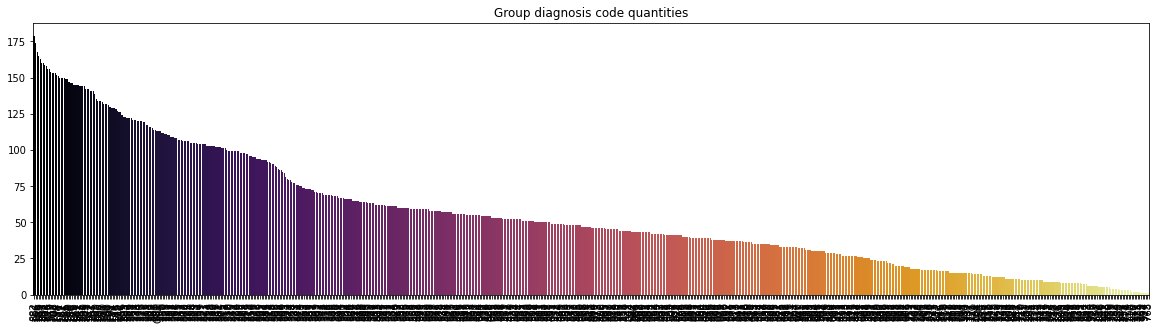

Top 10 diagnosis codes are 
 882    179
884    174
166    168
183    165
939    163
168    160
883    160
887    159
204    158
945    156
Name: DiagnosisGroupCode, dtype: int64


In [52]:
# Group diagnosis code
plt.figure(figsize=(20,5))
plt.title('Group diagnosis code quantities')
sns.barplot(x=inp_data.DiagnosisGroupCode.value_counts().index,y=inp_data.DiagnosisGroupCode.value_counts().values,palette='inferno')
plt.xticks(rotation=90)
plt.show()
print('Top 10 diagnosis codes are \n',inp_data.DiagnosisGroupCode.value_counts()[:10])

**Outpatient data**

Much more outpatient claims than inpatient. Similar reducing trend is also observed here.

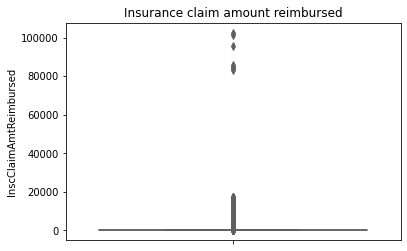

In [53]:
#Outpatient InsclaimReimb
plt.title('Insurance claim amount reimbursed')
sns.boxplot(y=out_data.InscClaimAmtReimbursed,palette='Blues')
# plt.ylim(0,1000)
plt.show()

Outliers seem to be very separated from frequently occuring data but not much is clear..

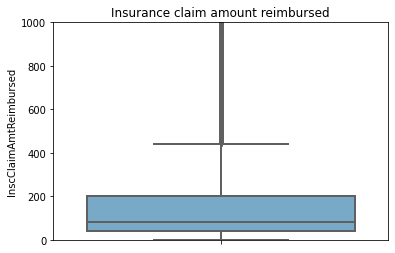

In [54]:
plt.title('Insurance claim amount reimbursed')
sns.boxplot(y=out_data.InscClaimAmtReimbursed,palette='Blues',linewidth=2)
plt.ylim(0,1000)
plt.show()

Most outdoor patients seem to have claims under 400

In [55]:
print('Missing values in attending physician',out_data.AttendingPhysician.isnull().sum())
print('Missing values in operating physician',out_data.OperatingPhysician.isnull().sum())
print('Missing values in other physician',out_data.OtherPhysician.isnull().sum())

Missing values in attending physician 1396
Missing values in operating physician 427120
Missing values in other physician 322691


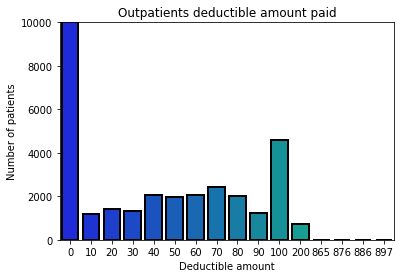

Total number of patients who not paid deductible amount 496701


In [56]:
plt.title('Outpatients deductible amount paid')
sns.barplot(x=out_data.DeductibleAmtPaid.value_counts().index,y=out_data.DeductibleAmtPaid.value_counts().values,palette='winter',linewidth=2,edgecolor='black')
plt.xlabel('Deductible amount')
plt.ylabel('Number of patients')
plt.ylim(0,10000)
plt.show()
print('Total number of patients who not paid deductible amount',out_data.DeductibleAmtPaid.value_counts()[0])

Most patients do not have to pay any kind of deductible amount.This amount is probably be paid by the government.

**Benefeciary data**

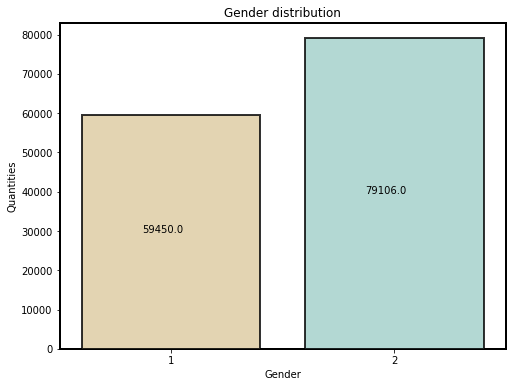

In [57]:
bar_plot(ben_data.Gender.value_counts().index,ben_data.Gender.value_counts().values,'Gender','Quantities','Gender distribution',True)

We see a minor imbalance between genders nothing to worry about.

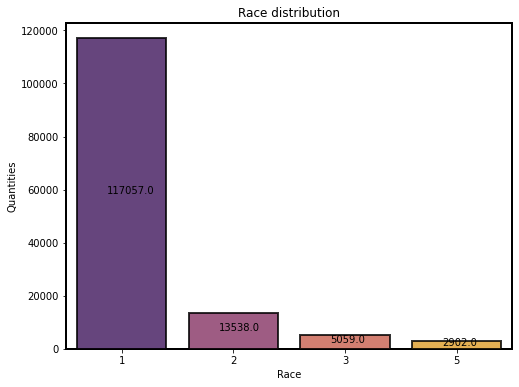

In [58]:
bar_plot(ben_data.Race.value_counts().index,ben_data.Race.value_counts().values,xlab='Race',ylab='Quantities',title='Race distribution',annotate=True)

**Merging inpatient+outpatient+benefeciary+provider**


In [59]:
#merging inpatient and outpatient data
cols=list(set(inp_data.columns).intersection(set(out_data.columns)))
patient=inp_data.merge(out_data,how='outer',on=cols)

In [60]:
patient_int=ben_data.merge(patient,how='outer',on='BeneID')

In [61]:
patient_fin=patient_int.merge(train_data,how='outer',on='Provider')

Now we have the target variable so we can visualize interaction features.

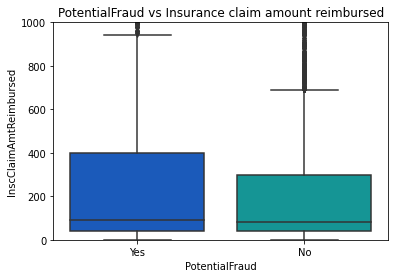

In [62]:
plt.title('PotentialFraud vs Insurance claim amount reimbursed')
sns.boxplot(y='InscClaimAmtReimbursed',x='PotentialFraud',data=patient_fin,palette='winter')
plt.ylim(0,1000)
plt.show()

The upper whisker in the boxplot is higher for fraudulent transaction than non fraudulent. 

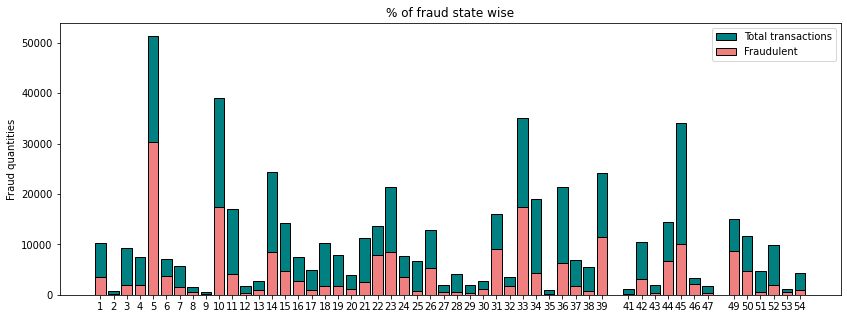

In [63]:
temp1=patient_fin.groupby('State')['PotentialFraud'].agg(lambda x:x.eq('Yes').sum()).reset_index() #aggregates state wise potential fraud
temp2=patient_fin.groupby('State')['PotentialFraud'].agg(lambda x:x.eq('No').sum()).reset_index()
temp3=temp1['PotentialFraud']+temp2['PotentialFraud']
plt.figure(figsize=(14,5))
plt.title('State vs Potential Fraud')
p1=plt.bar(temp1['State'],temp3,edgecolor='black',color='teal')
p2=plt.bar(temp1['State'],temp1['PotentialFraud'],edgecolor='black',color='lightcoral')
plt.ylabel('Fraud quantities')
plt.title('% of fraud state wise')
plt.xticks(temp1['State'], list(temp1['State'].values))
plt.legend((p1[0], p2[0]), ('Total transactions', 'Fraudulent'))
plt.show()
#code for simple annotation
# for p in ax.patches:
#   ax.annotate(p.get_height(), (p.get_x()+p.get_width()/3. * 1.005, p.get_height() * 1.005))

In states 5,10,33 & 45 transactions are high and fraudulent transactions are also high.

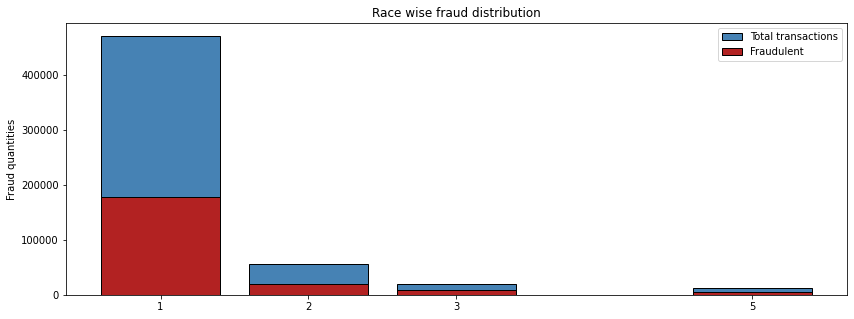

% fraud transactions racewise


[(1, 0.37862286534362555),
 (2, 0.36455787203450757),
 (3, 0.45457773269084456),
 (5, 0.4403553299492386)]

In [64]:
temp1=patient_fin.groupby('Race')['PotentialFraud'].agg(lambda x:x.eq('Yes').sum()).reset_index()
temp2=patient_fin.groupby('Race')['PotentialFraud'].agg(lambda x:x.eq('No').sum()).reset_index()
temp3=temp1['PotentialFraud']+temp2['PotentialFraud']
plt.figure(figsize=(14,5))
plt.title('Race vs Potential Fraud')
p1=plt.bar(temp1['Race'],temp3,edgecolor='black',color='steelblue')
p2=plt.bar(temp1['Race'],temp1['PotentialFraud'],edgecolor='black',color='firebrick')
plt.ylabel('Fraud quantities')
plt.title('Race wise fraud distribution')
plt.xticks(temp1['Race'], list(temp1['Race'].values))
plt.legend((p1[0], p2[0]), ('Total transactions', 'Fraudulent'))
plt.show()
print('% fraud transactions racewise')
[(temp1['Race'].loc[i],temp1['PotentialFraud'].loc[i]/temp3[i]) for i in range(len(temp1['PotentialFraud']))]

-There are no race 4 persons in dataset.

-Patients of race 3 and 5 are more susceptible to fraud

In [65]:
#label coding binary features
cols=['ChronicCond_Alzheimer','ChronicCond_Heartfailure','ChronicCond_KidneyDisease',
      'ChronicCond_Cancer','ChronicCond_ObstrPulmonary','ChronicCond_Depression','ChronicCond_Diabetes',
      'ChronicCond_IschemicHeart','ChronicCond_Osteoporasis','ChronicCond_rheumatoidarthritis',
      'ChronicCond_stroke']
for i in cols:
  patient_fin[i]=patient_fin[i].map({1:0,2:1})

In [66]:
patient_fin.RenalDiseaseIndicator=patient_fin.RenalDiseaseIndicator.map({'0':0,'Y':1})

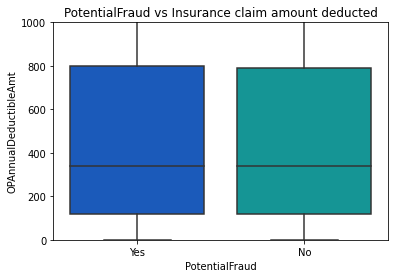

In [67]:
plt.title('PotentialFraud vs Insurance claim amount deducted')
sns.boxplot(y='OPAnnualDeductibleAmt',x='PotentialFraud',data=patient_fin,palette='winter')
plt.ylim(0,1000)
plt.show()

Deductible amount is very similar for fraud and non fraud.

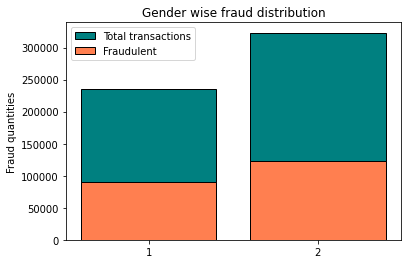

% fraud transactions Genderwise


[(1, 0.38147232844315326), (2, 0.38102032100125655)]

In [68]:
temp1=patient_fin.groupby('Gender')['PotentialFraud'].agg(lambda x:x.eq('Yes').sum()).reset_index()
temp2=patient_fin.groupby('Gender')['PotentialFraud'].agg(lambda x:x.eq('No').sum()).reset_index()
temp3=temp1['PotentialFraud']+temp2['PotentialFraud']
plt.figure(figsize=(6,4))
plt.title('Gender vs Potential Fraud')
p1=plt.bar(temp1['Gender'],temp3,edgecolor='black',color='teal')
p2=plt.bar(temp1['Gender'],temp1['PotentialFraud'],edgecolor='black',color='coral')
plt.ylabel('Fraud quantities')
plt.title('Gender wise fraud distribution')
plt.xticks(temp1['Gender'], list(temp1['Gender'].values))
plt.legend((p1[0], p2[0]), ('Total transactions', 'Fraudulent'))
plt.show()
print('% fraud transactions Genderwise')
[(temp1['Gender'].loc[i],temp1['PotentialFraud'].loc[i]/temp3[i]) for i in range(len(temp1['PotentialFraud']))]

Both genders are equally prone to fraud.

#Feature Engineering

In [69]:
#Feature : settlement_Days
patient_fin['ClaimStartDt']=pd.to_datetime(patient_fin.ClaimStartDt,format='%Y-%m-%d')
patient_fin['ClaimEndDt']=pd.to_datetime(patient_fin.ClaimEndDt,format='%Y-%m-%d')
patient_fin['settlement_days']=patient_fin['ClaimEndDt']-patient_fin['ClaimStartDt']
patient_fin['settlement_days']=patient_fin['settlement_days'].dt.days

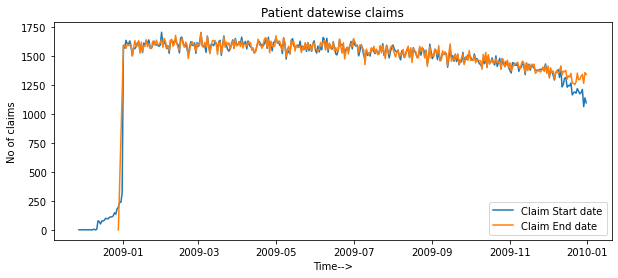

In [70]:
fig,ax=plt.subplots(figsize=(10,4))
plt.title('Patient datewise claims')
plt.xlabel('Time-->')
plt.ylabel('No of claims')
# sns.set_palette('inferno',n_colors=2)
sns.lineplot(x=patient_fin.ClaimStartDt.value_counts().sort_index().index,y=patient_fin.ClaimStartDt.value_counts().sort_index().values,label='Claim Start date')
sns.lineplot(x=patient_fin.ClaimEndDt.value_counts().sort_index().index,y=patient_fin.ClaimEndDt.value_counts().sort_index().values,label='Claim End date')
plt.show()

We see that patient wise claims are overally decreasing.

In [71]:
#feature: days_Admit
patient_fin['AdmissionDt']=pd.to_datetime(patient_fin['AdmissionDt'],format='%Y-%m-%d')
patient_fin['DischargeDt']=pd.to_datetime(patient_fin['DischargeDt'],format='%Y-%m-%d')
patient_fin['Days_Admit']=patient_fin['DischargeDt']-patient_fin['AdmissionDt']
patient_fin['Days_Admit']=patient_fin['Days_Admit'].dt.days

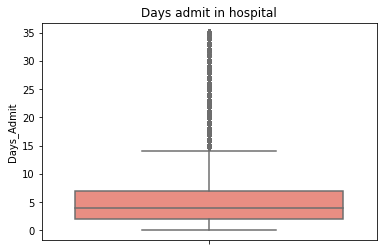

Max number of days a person was admitted= 35.0


In [72]:
plt.title('Days admit in hospital')
sns.boxplot(y=patient_fin.Days_Admit,palette='dark:salmon_r')
plt.show()
print('Max number of days a person was admitted=',max(patient_fin.Days_Admit))

Most people were discharged in 15 days.

In [73]:
#adding a feature inp_out signifying whether the patient was inpatient or outpatient
inp_out=patient_fin.Days_Admit.isnull()
inp_data=inp_out.map({True:1,False:0})
patient_fin['inp_out']=inp_data

In [74]:
#handling nan values generated due to merging inpatient and outpatient
patient_fin.Days_Admit.fillna(0,inplace=True)

In [75]:
#since no date is given in the problem statement we are taking last death as the latest day
last_death=max(patient_fin['DOD'][patient_fin['DOD'].notnull()])

In [76]:
#adding a feature representing whether the person is alive or not
patient_fin['Alive_or_not']=np.where(patient_fin['DOD'].isnull(),1,0)

In [77]:
patient_fin['DOD']=np.where(patient_fin['DOD'].isnull(),last_death,patient_fin['DOD'])

In [78]:
# datetime.strptime(ben_data['DOD'],"%Y-%m-%d")
# ben_data.apply(lambda x:datetime.strptime(x['DOD'],"%Y-%m-%d"))
patient_fin['DOD']=pd.to_datetime(patient_fin['DOD'],format='%Y-%m-%d')
patient_fin['DOB']=pd.to_datetime(patient_fin['DOB'],format='%Y-%m-%d')

In [79]:
#lets get the age of the patient
patient_fin=patient_fin.assign(Age=lambda x:(x['DOD']-x['DOB']))

In [80]:
patient_fin['Age']=patient_fin['Age'].dt.days/365

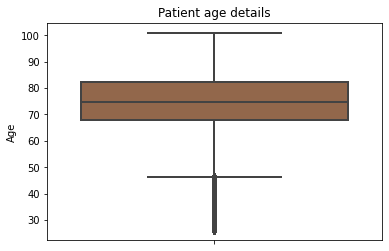

In [81]:
plt.title('Patient age details')
sns.boxplot(y=patient_fin.Age,palette='copper',linewidth=2)
plt.show()

Most people are having ages 45-100.

In [82]:
tot=0
for i in cols:
  tot+=patient_fin[i]
patient_fin['Total_disease']=tot  

In [83]:
patient_fin['Total_deductible']=patient_fin['OPAnnualDeductibleAmt']+patient_fin['IPAnnualDeductibleAmt']
patient_fin['Total_reimbursible']=patient_fin['OPAnnualReimbursementAmt']+patient_fin['IPAnnualReimbursementAmt']

In [84]:
#feature number of physician
val_op=[0 if i=='Not_Available' else 1 for i in patient_fin.OtherPhysician]
val_ap=[0 if i=='Not_Available' else 1 for i in patient_fin.AttendingPhysician]
val_opp=[0 if i=='Not_Available' else 1 for i in patient_fin.OperatingPhysician]  
patient_fin['Num_physician_rq']=[sum(x) for x in zip(val_op,val_ap,val_opp)]

**Handling missing values**

In [85]:
#before processing outliers lets drop irrelevant features
num_claims=patient_fin.groupby('Provider')['ClaimID'].nunique()
patient_fin.drop(['BeneID','DOB','DOD','ClaimID','ClaimStartDt','ClaimEndDt','AdmissionDt','DischargeDt'],axis=1,inplace=True)

In [86]:
#filling with zero representing out patient
patient_fin['Days_Admit'].fillna(0,inplace=True)
#for categorical columns we replace nan values as a class of its own


In [87]:
col_nan=patient_fin.columns[patient_fin.isna().any()]
for i in col_nan:
  patient_fin[i].fillna('Not_Available',inplace=True)

**Outlier analysis**

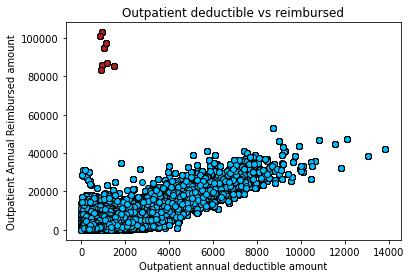

In [88]:
fig=plt.figure()
ax=fig.add_subplot(111)
# plot points inside distribution's width
ax.scatter(patient_fin['OPAnnualDeductibleAmt'],patient_fin['OPAnnualReimbursementAmt'],
           edgecolors='black',color="deepskyblue")
ax.scatter(patient_fin['OPAnnualDeductibleAmt'][patient_fin['OPAnnualReimbursementAmt']>80000],
           patient_fin['OPAnnualReimbursementAmt'][patient_fin['OPAnnualReimbursementAmt']>80000],
           edgecolors='black',color="firebrick")
ax.set_xlabel('Outpatient annual deductible amount')
ax.set_ylabel('Outpatient Annual Reimbursed amount')
ax.set_title('Outpatient deductible vs reimbursed')
plt.show()

We see that points in red are very separated from the rest of the point exhibiting outlierish behaviour.

In [89]:
patient_fin.drop(patient_fin[patient_fin['OPAnnualReimbursementAmt']>80000].index,inplace=True)

Other features too had outliers but they were conveying important information abou data. So we decided to leave them as it is

In [90]:
#label encoder
def label_encoder(X):
  if patient_fin[X].dtype=='object' and X!='Provider':
    patient_fin[X]=patient_fin[X].astype('category')
    patient_fin[X]=patient_fin[X].cat.codes
    patient_fin[X]=patient_fin[X].astype('category')

In [91]:
object_dtypes=patient_fin.select_dtypes(include='object').columns

In [92]:
[label_encoder(i) for i in object_dtypes]

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

Aggregating numerical features by provider

In [93]:
#Insurance claim reimbursed
Avg_clm_reimbursed=patient_fin.groupby('Provider')['InscClaimAmtReimbursed'].mean()
Tot_clm_reimbursed=patient_fin.groupby('Provider')['InscClaimAmtReimbursed'].sum()
#IPAnnualReimbursementAmt
Avg_inpclm_reimbursed=patient_fin.groupby('Provider')['IPAnnualReimbursementAmt'].mean()
Tot_inpclm_reimbursed=patient_fin.groupby('Provider')['IPAnnualReimbursementAmt'].sum()
#IPAnnualDeductibleAmt
Avg_inp_deductible=patient_fin.groupby('Provider')['IPAnnualDeductibleAmt'].mean()
Tot_inp_deductible=patient_fin.groupby('Provider')['IPAnnualDeductibleAmt'].sum()
#OPAnnualReimbursementAmt
Avg_out_reimbursement=patient_fin.groupby('Provider')['OPAnnualReimbursementAmt'].mean()
Tot_out_deductible=patient_fin.groupby('Provider')['OPAnnualReimbursementAmt'].sum()
#OPAnnualDeductibleAmt
Avg_out_deductible=patient_fin.groupby('Provider')['IPAnnualDeductibleAmt'].mean()
Tot_out_deductible=patient_fin.groupby('Provider')['IPAnnualDeductibleAmt'].sum()
#Age
Avg_age=patient_fin.groupby('Provider')['Age'].mean()
#settlement_days
Avg_settlement=patient_fin.groupby('Provider')['settlement_days'].mean()
Freq_settlement=patient_fin.groupby('Provider')['settlement_days'].agg(lambda x:x.value_counts().index[0])
#Days_Admit
Avg_days_admit=patient_fin.groupby('Provider')['Days_Admit'].mean()
#Num_physician_rq
Num_phys_rq=patient_fin.groupby('Provider')['Num_physician_rq'].mean()
#Total_deductible
Avg_total_deductible=patient_fin.groupby('Provider')['Total_deductible'].mean()
Sum_total_deductible=patient_fin.groupby('Provider')['Total_deductible'].sum()
#Total_reimbursible
Avg_total_reimbursible=patient_fin.groupby('Provider')['Total_reimbursible'].mean()
Sum_total_reimbursible=patient_fin.groupby('Provider')['Total_reimbursible'].sum()

In [94]:
Race_dummy=pd.get_dummies(patient_fin.Race)
patient_fin=pd.concat([patient_fin,Race_dummy],axis=1)
patient_fin.drop('Race',axis=1,inplace=True)

In [95]:
#Gender
Num_males=patient_fin.groupby('Provider')['Gender'].sum()
#Race features
Num_race1=patient_fin.groupby('Provider')[1].sum()
Num_race2=patient_fin.groupby('Provider')[2].sum()
Num_race3=patient_fin.groupby('Provider')[3].sum()
Num_race5=patient_fin.groupby('Provider')[5].sum()
#RenalDiseaseIndicator
Ren_disease=patient_fin.groupby('Provider')['RenalDiseaseIndicator'].sum()
#

In [96]:
Num_months_dummy=pd.get_dummies(patient_fin.NoOfMonths_PartACov)
Num_months_dummy.columns=['Month'+str(i) for i in range(13)]
patient_fin=pd.concat([patient_fin,Num_months_dummy],axis=1)
patient_fin.drop('NoOfMonths_PartACov',axis=1,inplace=True)

In [97]:
Month0=patient_fin.groupby('Provider')['Month0'].sum()
Month1=patient_fin.groupby('Provider')['Month1'].sum()
Month2=patient_fin.groupby('Provider')['Month2'].sum()
Month3=patient_fin.groupby('Provider')['Month3'].sum()
Month4=patient_fin.groupby('Provider')['Month4'].sum()
Month5=patient_fin.groupby('Provider')['Month5'].sum()
Month6=patient_fin.groupby('Provider')['Month6'].sum()
Month7=patient_fin.groupby('Provider')['Month7'].sum()
Month8=patient_fin.groupby('Provider')['Month8'].sum()
Month9=patient_fin.groupby('Provider')['Month9'].sum()
Month10=patient_fin.groupby('Provider')['Month10'].sum()
Month11=patient_fin.groupby('Provider')['Month11'].sum()
Month12=patient_fin.groupby('Provider')['Month12'].sum()

In [98]:
#medical cases counts
alzheimer_cnt=patient_fin.groupby('Provider')['ChronicCond_Alzheimer'].sum()
Hrt_failure=patient_fin.groupby('Provider')['ChronicCond_Heartfailure'].sum()
kidney_dis=patient_fin.groupby('Provider')['ChronicCond_KidneyDisease'].sum()
Cancer=patient_fin.groupby('Provider')['ChronicCond_Cancer'].sum()
Pulmonary=patient_fin.groupby('Provider')['ChronicCond_ObstrPulmonary'].sum()
Depression=patient_fin.groupby('Provider')['ChronicCond_Depression'].sum()
Diabetes=patient_fin.groupby('Provider')['ChronicCond_Diabetes'].sum()
chemicHeart=patient_fin.groupby('Provider')['ChronicCond_IschemicHeart'].sum()
Osteoporasis=patient_fin.groupby('Provider')['ChronicCond_Osteoporasis'].sum()
Rheumatoid=patient_fin.groupby('Provider')['ChronicCond_rheumatoidarthritis'].sum()
Stroke=patient_fin.groupby('Provider')['ChronicCond_stroke'].sum()

In [99]:
#number of unique attending physicians per provider
att_phys=patient_fin.groupby('Provider')['AttendingPhysician'].nunique()
op_phys=patient_fin.groupby('Provider')['OperatingPhysician'].nunique()
othr_phys=patient_fin.groupby('Provider')['OtherPhysician'].nunique()

In [100]:
#total number of unique diagnosis code per provider
diagnosis_codes=patient_fin.groupby('Provider')['ClmAdmitDiagnosisCode'].nunique()
diagnosis_grp_codes=patient_fin.groupby('Provider')['DiagnosisGroupCode'].nunique()
diagnosis_code1=patient_fin.groupby('Provider')['ClmDiagnosisCode_1'].nunique()
diagnosis_code2=patient_fin.groupby('Provider')['ClmDiagnosisCode_2'].nunique()
diagnosis_code3=patient_fin.groupby('Provider')['ClmDiagnosisCode_3'].nunique()
diagnosis_code4=patient_fin.groupby('Provider')['ClmDiagnosisCode_4'].nunique()
diagnosis_code5=patient_fin.groupby('Provider')['ClmDiagnosisCode_5'].nunique()
diagnosis_code6=patient_fin.groupby('Provider')['ClmDiagnosisCode_6'].nunique()
diagnosis_code7=patient_fin.groupby('Provider')['ClmDiagnosisCode_7'].nunique()
diagnosis_code8=patient_fin.groupby('Provider')['ClmDiagnosisCode_8'].nunique()
diagnosis_code9=patient_fin.groupby('Provider')['ClmDiagnosisCode_9'].nunique()
diagnosis_code10=patient_fin.groupby('Provider')['ClmDiagnosisCode_10'].nunique()

In [101]:
#total number of unique procedure codes per provider
procedure_code_1=patient_fin.groupby('Provider')['ClmProcedureCode_1'].nunique()
procedure_code_2=patient_fin.groupby('Provider')['ClmProcedureCode_2'].nunique()
procedure_code_3=patient_fin.groupby('Provider')['ClmProcedureCode_3'].nunique()
procedure_code_4=patient_fin.groupby('Provider')['ClmProcedureCode_4'].nunique()
procedure_code_5=patient_fin.groupby('Provider')['ClmProcedureCode_5'].nunique()
procedure_code_6=patient_fin.groupby('Provider')['ClmProcedureCode_6'].nunique()

In [102]:
num_inpatients=patient_fin.groupby('Provider')['inp_out'].sum()
num_outpatients=patient_fin.groupby('Provider')['inp_out'].count()-patient_fin.groupby('Provider')['inp_out'].sum()

In [103]:
unq_state=patient_fin.groupby('Provider')['State'].nunique()
unq_county=patient_fin.groupby('Provider')['County'].nunique()

In [104]:
patient_agg=pd.concat([procedure_code_1,procedure_code_2,procedure_code_3,
                       procedure_code_4,procedure_code_5,procedure_code_6,num_inpatients,
                       num_outpatients,diagnosis_codes,diagnosis_grp_codes,diagnosis_code1,
                       diagnosis_code2,diagnosis_code3,diagnosis_code4,diagnosis_code5,
                       diagnosis_code6,diagnosis_code7,diagnosis_code8,diagnosis_code9,diagnosis_code10,
                       att_phys,op_phys,othr_phys,alzheimer_cnt,Hrt_failure,
                       kidney_dis,Cancer,Pulmonary,Depression,Diabetes,chemicHeart,
                       Osteoporasis,Rheumatoid,Stroke,Month0,Month1,
                       Month2,Month3,Month4,Month5,Month6,Month7,Month8,
                       Month9,Month10,Month11,Month12,Num_males,Num_race1,
                       Num_race2,Num_race3,Num_race5,Ren_disease,Avg_clm_reimbursed,
                       Tot_clm_reimbursed,Avg_inpclm_reimbursed,Tot_inpclm_reimbursed,
                       Avg_inp_deductible,Tot_inp_deductible,Avg_out_reimbursement,
                       Tot_out_deductible,Avg_age,Avg_settlement,Freq_settlement,Avg_days_admit
                       ,Avg_total_deductible,Sum_total_deductible,Avg_total_reimbursible,
                       Sum_total_reimbursible,num_claims,unq_state,unq_county
                       ],axis=1)

In [105]:
provider=patient_agg.merge(train_data,how='inner',on='Provider')

In [106]:
provider.PotentialFraud=provider.PotentialFraud.map({'Yes':1,'No':0})

Now we have our aggregated features which can be used to predict whether a provider is fraudulent or not.This concludes our preprocessing and EDA. For further process we will first be splitting the dataset into train and test set in order to avoid data leakage.

In [140]:
#Doing the train test split
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(provider.drop('PotentialFraud',axis=1),provider['PotentialFraud'],test_size=0.2,stratify=provider['PotentialFraud'],random_state=42)

Lets find out correlation amongst feature variables.

**Feature selection**

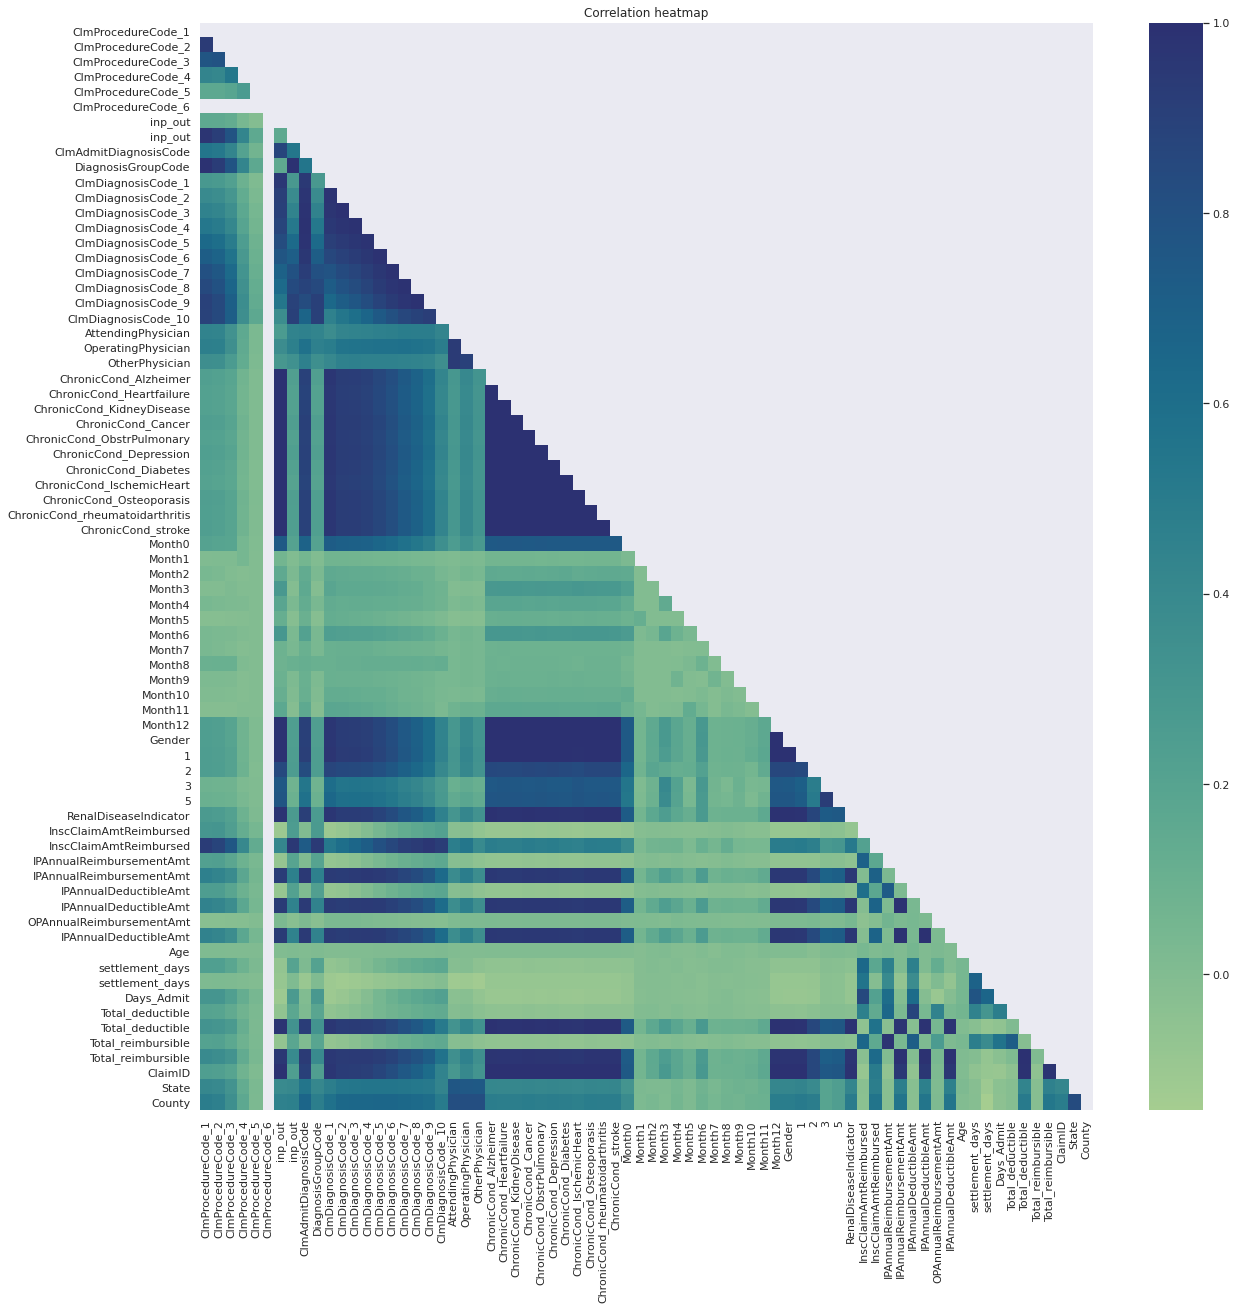

In [141]:
#finding the correlation amongst features
plt.figure(figsize=(20, 20))
plt.title('Correlation heatmap')
corr=X_train.corr()
mask=np.triu(corr)
sns.heatmap(corr,cmap='crest',mask=mask)
plt.show()

In [142]:
up=corr.where(np.triu(np.ones(corr.shape),k=1).astype(np.bool))

In [143]:
td=[col for col in up.columns if any(abs(up[col])>0.99)]

Dropping the highly correlated features..

In [144]:
X_train.drop(td,axis=1,inplace=True)
X_test.drop(td,axis=1,inplace=True)

Visualizing using a TSNE plot..

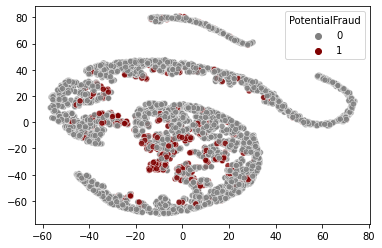

In [113]:
from sklearn.manifold import TSNE
colors=['gray','maroon']
customPalette = sns.set_palette(sns.color_palette(colors))
prov_emb=TSNE(n_components=2,perplexity=40,n_iter=1000).fit_transform(X_train.drop('Provider',axis=1))
sns.scatterplot(x=prov_emb[:,0],y=prov_emb[:,1],hue=y_train,palette=customPalette,alpha=0.8)

From TSNE plot we observe both classes are somewhat separable with non fraud class observation spread all over and fraudulent ones 

In [145]:
# prv_id=provider['Provider']
X_train.drop('Provider',axis=1,inplace=True)
X_test.drop('Provider',axis=1,inplace=True)

Lets find which features are important in making prediction..

In [146]:
from sklearn.ensemble import RandomForestClassifier
r_cfl=RandomForestClassifier(n_estimators=1000,random_state=42,n_jobs=-1)
r_cfl.fit(X_train,y_train)
# predict_y = r_cfl.predict(provider.drop('PotentialFraud',axis=1))

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

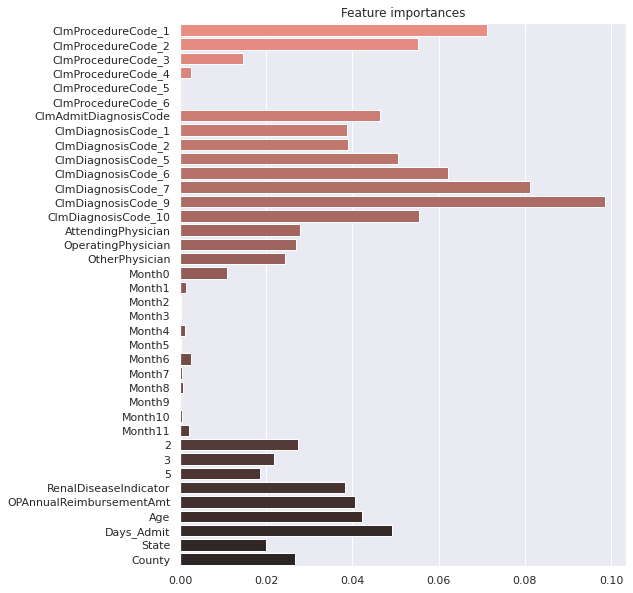

In [147]:
features=X_train.columns
coef = pd.Series(r_cfl.feature_importances_,features).sort_values()
plt.figure(figsize=(8,10))
plt.title('Feature importances')
sns.barplot(x=r_cfl.feature_importances_,y=features,palette='dark:salmon_r')
plt.show()

We see that features like Month0-12,procedurecode5,6 and physician required are not contributing much in prediction of random forest model. So we decide to drop these features.

In [148]:
#dropping less important features
coef=coef[coef<0.005].index
X_train.drop(coef,axis=1,inplace=True)
X_test.drop(coef,axis=1,inplace=True)

As we have already seen there was class imbalance we need to address the issue before moving forward. We can try following approaches

-Resampling (Over sampling)

-Creating synthetic samples of minority class

-Balancing class weights

-Clustering based resampling

-Clustering based sampling and aggregation

#Modelling

In [149]:
def Heatmapgen(x):
#https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea referred from here
  group_names = ['True -ve','False +ve','False -ve','True +ve']
  group_counts = ['{0:0.0f}'.format(value) for value in x.flatten()]
  labels = [f'{v1}\n{v2}' for v1, v2 in
  zip(group_names,group_counts)]
  labels = np.asarray(labels).reshape(2,2)
  sns.heatmap(x, annot=labels, fmt='', cmap='RdBu')

Random Oversampling

In [150]:
#Random oversampling
from imblearn.over_sampling import RandomOverSampler
oversample = RandomOverSampler(sampling_strategy='minority')
X_over, y_over = oversample.fit_resample(X_train, y_train)

In [151]:
from sklearn.metrics import f1_score
r_cfl=RandomForestClassifier(n_estimators=1000,random_state=21,n_jobs=-1)
r_cfl.fit(X_over,y_over)
predict_y = r_cfl.predict(X_test)
print('F1 score on oversampled data:',f1_score(y_test,predict_y))

F1 score on oversampled data: 0.6464646464646465


Synthetic minority oversampling(SMOTE)

In [152]:
#Synthetic oversampling
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
X_synt, y_synt = oversample.fit_resample(X_train, y_train)

In [ ]:
r_cfl=RandomForestClassifier(n_estimators=1000,random_state=42,n_jobs=-1)
r_cfl.fit(X_synt,y_synt)
predict_y = r_cfl.predict(X_test)
print('F1 score on oversampled data:',f1_score(y_test,predict_y))

F1 score on oversampled data: 0.5833333333333334


Class weights balancing

In [ ]:
#using balanced class weights
r_cfl=RandomForestClassifier(n_estimators=1000,random_state=42,n_jobs=-1,class_weight='balanced_subsample')
r_cfl.fit(X_train,y_train)
predict_y = r_cfl.predict(X_test)
print('F1 score on oversampled data:',f1_score(y_test,predict_y))

F1 score on oversampled data: 0.6046511627906976


Cluster based resampling:

https://www.quora.com/In-classification-how-do-you-handle-an-unbalanced-training-set


Idea: 

In this approach we will divide the majority class data into *k* clusters where *k* being the number of points in the minority class. Then of these cluster we can find the cluster centroids and use it instead of majority class data. Now due to resampling we have our classes balanced.

In [ ]:
#clustering based resampling
from sklearn.cluster import KMeans
model = KMeans(n_clusters=y_train.value_counts()[1]) #making same number of clusters as minority class
model.fit(X_train)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=455, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [ ]:
X_clust=model.cluster_centers_
X_pos=X_train[y_train==1]
X_clust=np.vstack((X_pos.values,X_clust))
y_clust=[1 if i>455 else 0 for i in range(910)]

In [ ]:
r_cfl=RandomForestClassifier(n_estimators=1000,random_state=42,n_jobs=-1)
r_cfl.fit(X_clust,y_clust)
predict_y = r_cfl.predict(X_test)
print('F1 score on oversampled data:',f1_score(y_test,predict_y))

F1 score on oversampled data: 0.27522935779816515


https://www.quora.com/In-classification-how-do-you-handle-an-unbalanced-training-set

Clustering and aggregation:

Idea:

In order to handle class imbalance we can divide the abundant class labels into *L* number of clusters.Then we will build *L* models each of which will be trained on (individual cluster+minority class data).We will evaluate on test set data. After getting the predictions we will do a majority vote and predict the majority as class label

In [ ]:
X_neg=X_train[y_train==0]
X_pos=X_train[y_train==1]
from sklearn.cluster import KMeans
model = KMeans(n_clusters=3,tol=0.001,max_iter=500,n_init=20) #making same number of clusters as minority class
model.fit(X_neg)
label=model.labels_

In [ ]:
predictions=[]
for i in range(5):
  X_1=np.vstack((X_pos,X_neg[label==i]))
  y_1=[1 if i<455 else 0 for i in range(455+len(X_neg[label==i]))]
  r_cfl=RandomForestClassifier(n_estimators=1000,random_state=42,n_jobs=-1)
  r_cfl.fit(X_1,y_1)
  predict_y = r_cfl.predict(X_test)
  predictions.append(predict_y)
  print('F1 score on oversampled data:',f1_score(y_test,predict_y,average='macro'))
  # plot_confusion_matrix(y_test,predict_y)

F1 score on oversampled data: 0.7116204690831557
F1 score on oversampled data: 0.10278227010991048
F1 score on oversampled data: 0.20349709147691203
F1 score on oversampled data: 0.08614864864864864
F1 score on oversampled data: 0.08614864864864864


In [ ]:
sum=0
for i in predictions:
  sum+=i
y_pred=np.where(sum>2,1,0)
f1_score(y_test,y_pred)

0.17229729729729729

Repeated random undersampling and aggregation

Idea:

We can randomly sample points from majority class labels of size same as minority class labels. Then we will build *k* such classifiers on (sampled data+minority class data). We will get the predictions from *k* models and will do a majority vote to predict the final output.

In [ ]:
predictions=[]
for i in range(11):
  ch=int(np.random.uniform(0,3900))                   #randomly selecting samples from majority class
  X_samp=X_neg.iloc[ch:ch+455]
  X_clust=np.vstack((X_pos.values,X_samp))            #stacking both +ve sampled class and -ve class and training
  y_clust=[1 if i<455 else 0 for i in range(910)]
  r_cfl=RandomForestClassifier(n_estimators=1000,random_state=42,n_jobs=-1)
  r_cfl.fit(X_clust,y_clust)
  predict_y = r_cfl.predict(X_test)                   #predicting on test data
  predictions.append(predict_y)
  print('F1 score:',f1_score(y_test,predict_y))

F1 score: 0.48275862068965514
F1 score: 0.5030674846625767
F1 score: 0.49696969696969695
F1 score: 0.4938271604938272
F1 score: 0.49710982658959546
F1 score: 0.4912280701754386
F1 score: 0.49438202247191004
F1 score: 0.5185185185185186
F1 score: 0.4970414201183432
F1 score: 0.47953216374269014
F1 score: 0.5060240963855422


In [ ]:
#based on majority votes predicting the f1 score
sum=0
for i in predictions:
  sum+=i
y_pred=np.where(sum>5,1,0)
f1_score(y_test,y_pred)  

0.4939759036144578

From above trials we saw that simple oversampling of minority class labels gave a high F1 score the complex methods.

With this we are ready for modelling. We will use random oversampling and class weight balancing technique to address the class imbalance..

**Model Building**

We wiil be using oversampling method in order to address class imbalance. But we cannot use oversampled data for validation as it will cause data leakage. Instead we will build a pipeline to ensure there is no leakage whatsoever..

Below blog explains it beautifully..

https://medium.com/lumiata/cross-validation-for-imbalanced-datasets-9d203ba47e8#:~:text=Techniques%20like%20oversampling%2FSMOTE%20help,exclude%20some%20data%20for%20validation.

**1 K Nearest Neighbors**

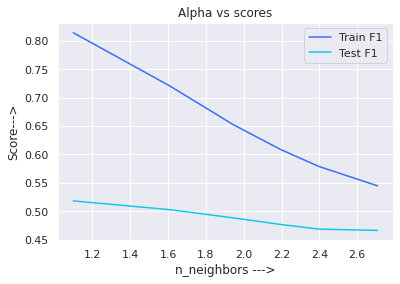

Best estimator : {'model__n_neighbors': 3}
Best score: 0.5182023224872998


In [257]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from imblearn.pipeline import Pipeline
import math
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
steps=list()
param={'model__n_neighbors':[3,5,7,9,11,15]}
steps.append(('scaler', StandardScaler()))
steps.append(('sampling',RandomOverSampler()))
steps.append(('model', KNeighborsClassifier()))
pipeline = Pipeline(steps=steps)
clf = GridSearchCV(pipeline, param, cv=10, scoring='f1',return_train_score=True)
clf.fit(X_train,y_train)
result_clf=pd.DataFrame.from_dict(clf.cv_results_)
result_clf=result_clf.sort_values('param_model__n_neighbors')
result_cv=result_clf['mean_test_score']
result_train=result_clf['mean_train_score']
alpha_vals = [math.log(i) for i in result_clf['param_model__n_neighbors']]
plt.figure(figsize=(6,4))
sns.lineplot(x=alpha_vals,y=result_train,markers='o',label='Train F1')
sns.lineplot(x=alpha_vals,y=result_cv,markers='o',label='Test F1')
sns.set(palette='rainbow')
plt.xlabel('n_neighbors --->')
plt.ylabel('Score--->')
plt.title('Alpha vs scores')
plt.show()
print('Best estimator :',clf.best_params_)
print('Best score:',clf.best_score_)

In [258]:
q=clf.predict(X_test)
print('Test F1 score:',f1_score(y_test,q))

Test F1 score: 0.5


**2 Naive Bayes classifier**

In [267]:
from sklearn.naive_bayes import GaussianNB
clf=GaussianNB(priors=[0.9,0.1])
clf.fit(X_train,y_train)
ytr_pred=clf.predict(X_train)
print('Train set F1 score :',f1_score(y_train,ytr_pred))
q=clf.predict(X_test)
print('Test set F1 score :',f1_score(y_test,q))

Train set F1 score : 0.5449218750000001
Test set F1 score : 0.5454545454545455


**3 SVM**

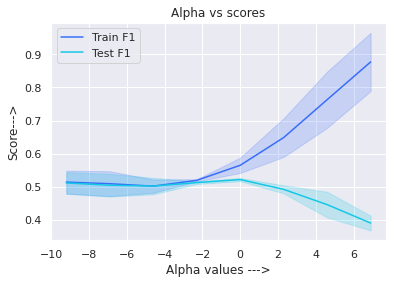

Best estimator : {'model__C': 0.0001, 'model__gamma': 'scale'}
Best score: 0.5441427261880476


In [268]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from imblearn.pipeline import Pipeline
import math
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
steps=list()
param={'model__C':[10**i for i in range(-4,4)],'model__gamma':['scale','auto']}
steps.append(('scaler', StandardScaler()))
steps.append(('sampling',RandomOverSampler()))
steps.append(('model', SVC()))
pipeline = Pipeline(steps=steps)
clf = GridSearchCV(pipeline, param, cv=10, scoring='f1',return_train_score=True)
clf.fit(X_train,y_train)
result_clf=pd.DataFrame.from_dict(clf.cv_results_)
result_clf=result_clf.sort_values('param_model__C')
result_cv=result_clf['mean_test_score']
result_train=result_clf['mean_train_score']
alpha_vals = [math.log(i) for i in result_clf['param_model__C']]
plt.figure(figsize=(6,4))
sns.lineplot(x=alpha_vals,y=result_train,markers='o',label='Train F1')
sns.lineplot(x=alpha_vals,y=result_cv,markers='o',label='Test F1')
sns.set(palette='rainbow')
plt.xlabel('Alpha values --->')
plt.ylabel('Score--->')
plt.title('Alpha vs scores')
plt.show()
print('Best estimator :',clf.best_params_)
print('Best score:',clf.best_score_)

In [269]:
q=clf.predict(X_test)
print('Test F1 score:',f1_score(y_test,q))

Test F1 score: 0.5641025641025642


**4.DecisionTree**

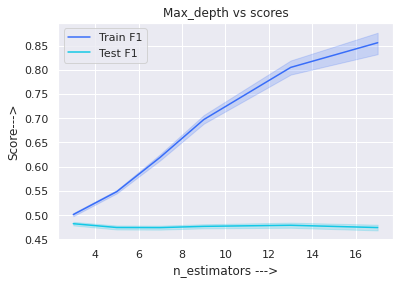

Best estimator : {'model__criterion': 'gini', 'model__max_depth': 13, 'model__min_samples_leaf': 11, 'model__min_samples_split': 5}
Best score: 0.536315045583449


In [ ]:
from sklearn.tree import DecisionTreeClassifier
param={'model__max_depth':[3,5,7,9,13,17]
       ,'model__min_samples_split':[3,5,7,11]
       ,'model__criterion':['gini','entropy'],
       'model__min_samples_leaf':[1,3,5,7,11]
       }
steps=[]
steps.append(('sampling',RandomOverSampler()))       
steps.append(('model', DecisionTreeClassifier()))
pipeline = Pipeline(steps=steps)
clf = GridSearchCV(pipeline, param, cv=3, scoring='f1',return_train_score=True)
clf.fit(X_train.values,y_train)
result_clf=pd.DataFrame.from_dict(clf.cv_results_)
result_clf=result_clf.sort_values('param_model__max_depth')
result_cv=result_clf['mean_test_score']
result_train=result_clf['mean_train_score']
alpha_vals = [i for i in result_clf['param_model__max_depth']]
plt.figure(figsize=(6,4))
sns.lineplot(x=alpha_vals,y=result_train,markers='o',label='Train F1')
sns.lineplot(x=alpha_vals,y=result_cv,markers='o',label='Test F1')
sns.set(palette='rainbow')
plt.xlabel('n_estimators --->')
plt.ylabel('Score--->')
plt.title('Max_depth vs scores')
plt.show()
print('Best estimator :',clf.best_params_)
print('Best score:',clf.best_score_)

In [ ]:
q=clf.predict(X_test.values)
f1_score(q,y_test)

0.5448028673835126

**5 Logistic Regression**

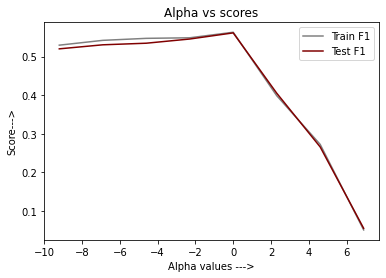

Best estimator : {'model__alpha': 1}
Best score: 0.5614456450637259


In [124]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from imblearn.pipeline import Pipeline
import math
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
steps=list()
param={'model__alpha':[10**i for i in range(-4,4)]}
steps.append(('scaler', StandardScaler()))
steps.append(('sampling',RandomOverSampler()))
steps.append(('model', SGDClassifier()))
pipeline = Pipeline(steps=steps)
clf = GridSearchCV(pipeline, param, cv=10, scoring='f1',return_train_score=True)
clf.fit(X_train,y_train)
result_clf=pd.DataFrame.from_dict(clf.cv_results_)
result_clf=result_clf.sort_values('param_model__alpha')
result_cv=result_clf['mean_test_score']
result_train=result_clf['mean_train_score']
alpha_vals = [math.log(i) for i in result_clf['param_model__alpha']]
plt.figure(figsize=(6,4))
sns.lineplot(x=alpha_vals,y=result_train,markers='o',label='Train F1')
sns.lineplot(x=alpha_vals,y=result_cv,markers='o',label='Test F1')
sns.set(palette='rainbow')
plt.xlabel('Alpha values --->')
plt.ylabel('Score--->')
plt.title('Alpha vs scores')
plt.show()
print('Best estimator :',clf.best_params_)
print('Best score:',clf.best_score_)

In [125]:
q=clf.predict(X_test)
print('Test F1 score:',f1_score(y_test,q))

Test F1 score: 0.5693430656934306


**6. Random Forest Classifier**

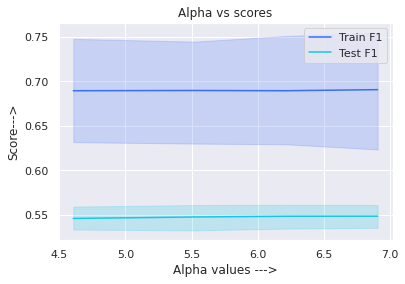

Best estimator : {'model__max_depth': 13, 'model__min_samples_split': 7, 'model__n_estimators': 250}
Best score: 0.5879258688393139


In [249]:
import math
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
param={'model__n_estimators':[100,250,500,1000],
       'model__max_depth':[3,5,7,9,13],
      'model__min_samples_split':[2,5,7,9]
       }
steps=[]
steps.append(('sampling',RandomOverSampler()))       
steps.append(('model', RandomForestClassifier(random_state=21)))
pipeline = Pipeline(steps=steps)
clf = GridSearchCV(pipeline, param, cv=10, scoring='f1',return_train_score=True)
clf.fit(X_train,y_train)
result_clf=pd.DataFrame.from_dict(clf.cv_results_)
result_clf=result_clf.sort_values('param_model__n_estimators')
result_cv=result_clf['mean_test_score']
result_train=result_clf['mean_train_score']
alpha_vals = [math.log(i) for i in result_clf['param_model__n_estimators']]
plt.figure(figsize=(6,4))
sns.lineplot(x=alpha_vals,y=result_train,markers='o',label='Train F1')
sns.lineplot(x=alpha_vals,y=result_cv,markers='o',label='Test F1')
sns.set(palette='rainbow')
plt.xlabel('Alpha values --->')
plt.ylabel('Score--->')
plt.title('Alpha vs scores')
plt.show()
print('Best estimator :',clf.best_params_)
print('Best score:',clf.best_score_)

In [250]:
q=clf.predict(X_test)
print('Test F1 score:',f1_score(y_test,q))

Test F1 score: 0.6115702479338843


**7 XgBoost with oversampling**

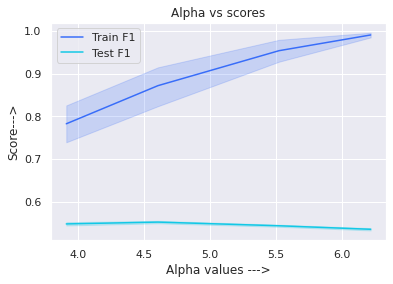

Best estimator : {'model__col_sample_bytree': 0.7, 'model__max_depth': 7, 'model__n_estimators': 100, 'model__subsample': 0.5}
Best score: 0.5723750673384669


In [255]:
import math
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
param={'model__n_estimators':[50,100,250,500]
       ,'model__max_depth':[3,5,7,9]
       ,'model__col_sample_bytree':[0.3,0.5,0.7]
       ,'model__subsample':[0.5,0.7,0.9]
       }
steps=[]
steps.append(('sampling',RandomOverSampler()))       
steps.append(('model', XGBClassifier()))
pipeline = Pipeline(steps=steps)
clf = GridSearchCV(pipeline, param, cv=3, scoring='f1',return_train_score=True)
clf.fit(X_train.values,y_train)
result_clf=pd.DataFrame.from_dict(clf.cv_results_)
result_clf=result_clf.sort_values('param_model__n_estimators')
result_cv=result_clf['mean_test_score']
result_train=result_clf['mean_train_score']
alpha_vals = [math.log(i) for i in result_clf['param_model__n_estimators']]
plt.figure(figsize=(6,4))
sns.lineplot(x=alpha_vals,y=result_train,markers='o',label='Train F1')
sns.lineplot(x=alpha_vals,y=result_cv,markers='o',label='Test F1')
sns.set(palette='rainbow')
plt.xlabel('Alpha values --->')
plt.ylabel('Score--->')
plt.title('Alpha vs scores')
plt.show()
print('Best estimator :',clf.best_params_)
print('Best score:',clf.best_score_)

In [256]:
q=clf.predict(X_test.values)
f1_score(q,y_test)

0.6050420168067226

**8. XGBoost with class weight balancing**

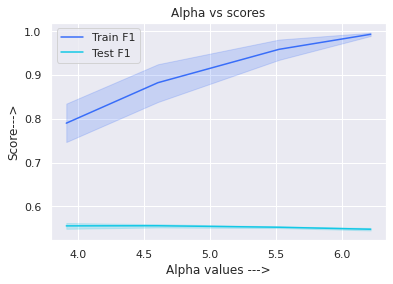

Best estimator : {'model__col_sample_bytree': 0.3, 'model__max_depth': 9, 'model__n_estimators': 50, 'model__subsample': 0.7}
Best score: 0.5842871745411038


In [165]:
import math
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
param={'model__n_estimators':[50,100,250,500]
       ,'model__max_depth':[3,5,7,9]
       ,'model__col_sample_bytree':[0.3,0.5,0.7]
       ,'model__subsample':[0.5,0.7,0.9]
       }
steps=[]
# steps.append(('sampling',RandomOverSampler()))       
steps.append(('model', XGBClassifier(scale_pos_weight=9)))
pipeline = Pipeline(steps=steps)
clf = GridSearchCV(pipeline, param, cv=3, scoring='f1',return_train_score=True)
clf.fit(X_train.values,y_train)
result_clf=pd.DataFrame.from_dict(clf.cv_results_)
result_clf=result_clf.sort_values('param_model__n_estimators')
result_cv=result_clf['mean_test_score']
result_train=result_clf['mean_train_score']
alpha_vals = [math.log(i) for i in result_clf['param_model__n_estimators']]
plt.figure(figsize=(6,4))
sns.lineplot(x=alpha_vals,y=result_train,markers='o',label='Train F1')
sns.lineplot(x=alpha_vals,y=result_cv,markers='o',label='Test F1')
sns.set(palette='rainbow')
plt.xlabel('Alpha values --->')
plt.ylabel('Score--->')
plt.title('Alpha vs scores')
plt.show()
print('Best estimator :',clf.best_params_)
print('Best score:',clf.best_score_)

In [166]:
q=clf.predict(X_test.values)
f1_score(q,y_test)

0.6515837104072398

F1 score on test set = 0.6515837104072398


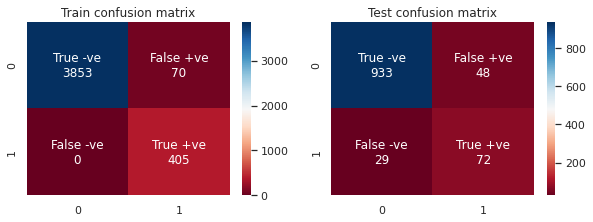

In [168]:
fig = plt.figure(figsize=(10,7))
ax1 = fig.add_subplot(221)
print("="*100)
from sklearn.metrics import confusion_matrix
cf_matr1=confusion_matrix(y_train,clf.predict(X_train.values))
plt.title('Train confusion matrix')
Heatmapgen(cf_matr1)
ax2 = fig.add_subplot(222)
cf_matr2=confusion_matrix(y_test,clf.predict(X_test.values))
plt.title('Test confusion matrix')
Heatmapgen(cf_matr2)
print('F1 score on test set =',f1_score(y_test,clf.predict(X_test.values)))

**9. LGBM classifier with oversampling**

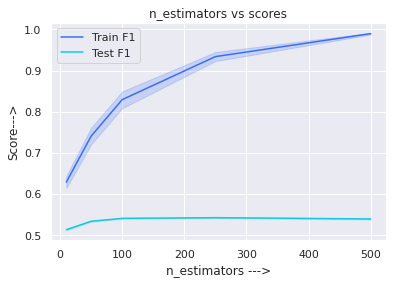

Best estimator : {'model__max_depth': 7, 'model__min_data_in_leaf': 11, 'model__min_gain_to_split': 0.3, 'model__n_estimators': 500, 'model__num_leaves': 32}
Best score: 0.5698382234096243


In [128]:
from lightgbm import LGBMClassifier
import math
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
param={'model__n_estimators':[10,50,100,250,500]
       ,'model__max_depth':[3,5,7,9]
       ,'model__min_data_in_leaf':[3,5,7,11]
       ,'model__min_gain_to_split':[0.0,0.1,0.3],
       'model__num_leaves':[8,32,64,96]
       }
steps=[]
steps.append(('sampling',RandomOverSampler()))       
steps.append(('model', LGBMClassifier()))
pipeline = Pipeline(steps=steps)
clf = GridSearchCV(pipeline, param, cv=3, scoring='f1',return_train_score=True)
clf.fit(X_train.values,y_train)
result_clf=pd.DataFrame.from_dict(clf.cv_results_)
result_clf=result_clf.sort_values('param_model__n_estimators')
result_cv=result_clf['mean_test_score']
result_train=result_clf['mean_train_score']
alpha_vals = [i for i in result_clf['param_model__n_estimators']]
plt.figure(figsize=(6,4))
sns.lineplot(x=alpha_vals,y=result_train,markers='o',label='Train F1')
sns.lineplot(x=alpha_vals,y=result_cv,markers='o',label='Test F1')
sns.set(palette='rainbow')
plt.xlabel('n_estimators --->')
plt.ylabel('Score--->')
plt.title('n_estimators vs scores')
plt.show()
print('Best estimator :',clf.best_params_)
print('Best score:',clf.best_score_)

In [129]:
q=clf.predict(X_test.values)
f1_score(q,y_test)

0.5299145299145299

**10. LightGBM with weight balancing**

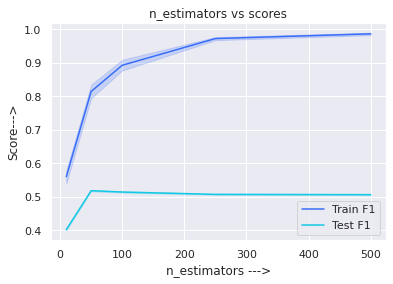

Best estimator : {'model__max_depth': 3, 'model__min_data_in_leaf': 11, 'model__min_gain_to_split': 0.0, 'model__n_estimators': 50, 'model__num_leaves': 8}
Best score: 0.5541855582289079


In [162]:
from lightgbm import LGBMClassifier
import math
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
param={'model__n_estimators':[10,50,100,250,500]
       ,'model__max_depth':[3,5,7,9]
       ,'model__min_data_in_leaf':[3,5,7,11]
       ,'model__min_gain_to_split':[0.0,0.1,0.3],
       'model__num_leaves':[8,32,64,96]
       }
steps=[]
# steps.append(('sampling',RandomOverSampler()))       
steps.append(('model', LGBMClassifier()))
pipeline = Pipeline(steps=steps)
clf = GridSearchCV(pipeline, param, cv=3, scoring='f1',return_train_score=True)
clf.fit(X_train.values,y_train)
result_clf=pd.DataFrame.from_dict(clf.cv_results_)
result_clf=result_clf.sort_values('param_model__n_estimators')
result_cv=result_clf['mean_test_score']
result_train=result_clf['mean_train_score']
alpha_vals = [i for i in result_clf['param_model__n_estimators']]
plt.figure(figsize=(6,4))
sns.lineplot(x=alpha_vals,y=result_train,markers='o',label='Train F1')
sns.lineplot(x=alpha_vals,y=result_cv,markers='o',label='Test F1')
sns.set(palette='rainbow')
plt.xlabel('n_estimators --->')
plt.ylabel('Score--->')
plt.title('n_estimators vs scores')
plt.show()
print('Best estimator :',clf.best_params_)
print('Best score:',clf.best_score_)

In [163]:
q=clf.predict(X_test.values)
f1_score(q,y_test)

0.6551724137931033

F1 score on test set = 0.6551724137931033


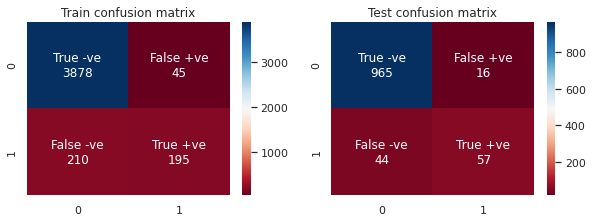

In [164]:
fig = plt.figure(figsize=(10,7))
ax1 = fig.add_subplot(221)
print("="*100)
from sklearn.metrics import confusion_matrix
cf_matr1=confusion_matrix(y_train,clf.predict(X_train))
plt.title('Train confusion matrix')
Heatmapgen(cf_matr1)
ax2 = fig.add_subplot(222)
cf_matr2=confusion_matrix(y_test,clf.predict(X_test))
plt.title('Test confusion matrix')
Heatmapgen(cf_matr2)
print('F1 score on test set =',f1_score(y_test,clf.predict(X_test)))

This model is giving comparable performance to Xgboost but at higher false negatives..

**11. Catboost**

In [ ]:
!pip install catboost

Streaming output truncated to the last 5000 lines.
0:	learn: 0.6374431	total: 36.9ms	remaining: 1.81s
1:	learn: 0.5752510	total: 72.7ms	remaining: 1.75s
2:	learn: 0.5299881	total: 107ms	remaining: 1.68s
3:	learn: 0.4868399	total: 142ms	remaining: 1.63s
4:	learn: 0.4476466	total: 177ms	remaining: 1.59s
5:	learn: 0.4194563	total: 211ms	remaining: 1.55s
6:	learn: 0.3957873	total: 253ms	remaining: 1.55s
7:	learn: 0.3706250	total: 287ms	remaining: 1.51s
8:	learn: 0.3433542	total: 322ms	remaining: 1.47s
9:	learn: 0.3192400	total: 356ms	remaining: 1.43s
10:	learn: 0.3003060	total: 391ms	remaining: 1.39s
11:	learn: 0.2837023	total: 426ms	remaining: 1.35s
12:	learn: 0.2738870	total: 468ms	remaining: 1.33s
13:	learn: 0.2590565	total: 509ms	remaining: 1.31s
14:	learn: 0.2509095	total: 544ms	remaining: 1.27s
15:	learn: 0.2417859	total: 581ms	remaining: 1.23s
16:	learn: 0.2320056	total: 618ms	remaining: 1.2s
17:	learn: 0.2246093	total: 661ms	remaining: 1.18s
18:	learn: 0.2181759	total: 708ms	remain

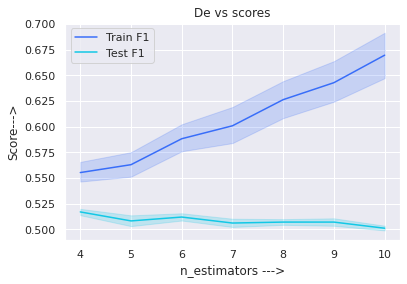

Best estimator : {'model__depth': 5, 'model__iterations': 100, 'model__learning_rate': 0.04}
Best score: 0.5436006495379874


In [172]:
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV
param = {'model__depth'         : [4,5,6,7,8,9, 10],
                 'model__learning_rate' : [0.01,0.02,0.03,0.04],
                  'model__iterations'    : [10, 20,30,40,50,60,70,80,90, 100]
                 }
steps=[]
# steps.append(('sampling',RandomOverSampler()))       
steps.append(('model', CatBoostClassifier()))
pipeline = Pipeline(steps=steps)
clf = GridSearchCV(pipeline, param, cv=3, scoring='f1',return_train_score=True)
clf.fit(X_train.values,y_train)
result_clf=pd.DataFrame.from_dict(clf.cv_results_)
result_clf=result_clf.sort_values('param_model__depth')
result_cv=result_clf['mean_test_score']
result_train=result_clf['mean_train_score']
alpha_vals = [i for i in result_clf['param_model__depth']]
plt.figure(figsize=(6,4))
sns.lineplot(x=alpha_vals,y=result_train,markers='o',label='Train F1')
sns.lineplot(x=alpha_vals,y=result_cv,markers='o',label='Test F1')
sns.set(palette='rainbow')
plt.xlabel('n_estimators --->')
plt.ylabel('Score--->')
plt.title('De vs scores')
plt.show()
print('Best estimator :',clf.best_params_)
print('Best score:',clf.best_score_)

In [173]:
q=clf.predict(X_test.values)
f1_score(q,y_test)

0.6242774566473989

F1 score on test set = 0.6242774566473989


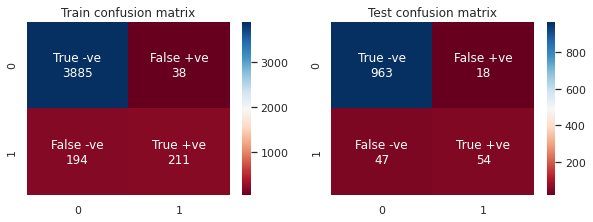

In [179]:
fig = plt.figure(figsize=(10,7))
ax1 = fig.add_subplot(221)
print("="*100)
from sklearn.metrics import confusion_matrix
cf_matr1=confusion_matrix(y_train,clf.predict(X_train))
plt.title('Train confusion matrix')
Heatmapgen(cf_matr1)
ax2 = fig.add_subplot(222)
cf_matr2=confusion_matrix(y_test,clf.predict(X_test))
plt.title('Test confusion matrix')
Heatmapgen(cf_matr2)
print('F1 score on test set =',f1_score(y_test,clf.predict(X_test)))

In [180]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names=['Sl No','Classifier Name','Train/Validation F1_scr','Test F1_Scr']
x.add_row([1,'KNN',0.518,0.500])
x.add_row([2,'Naive Bayes',0.544,0.545])
x.add_row([3,'SVM(rbf)',0.544,0.564])
x.add_row([4,'DecisionTree',0.536,0.544])
x.add_row([5,'Logistic Regression',0.561,0.569])
x.add_row([6,'Random Forest',0.587,0.611])
x.add_row([7,'XGBoost(Oversampling)',0.572,0.605])
x.add_row([8,'XGBoost(weight_balancing)',0.584,0.651])
x.add_row([9,'LightGBM(oversampling)',0.569,0.529])
x.add_row([10,'LightGBM',0.554,0.655])
x.add_row([11,'Catboost',0.543,0.624])
print(x)

+-------+---------------------------+-------------------------+-------------+
| Sl No |      Classifier Name      | Train/Validation F1_scr | Test F1_Scr |
+-------+---------------------------+-------------------------+-------------+
|   1   |            KNN            |          0.518          |     0.5     |
|   2   |        Naive Bayes        |          0.544          |    0.545    |
|   3   |          SVM(rbf)         |          0.544          |    0.564    |
|   4   |        DecisionTree       |          0.536          |    0.544    |
|   5   |    Logistic Regression    |          0.561          |    0.569    |
|   6   |       Random Forest       |          0.587          |    0.611    |
|   7   |   XGBoost(Oversampling)   |          0.572          |    0.605    |
|   8   | XGBoost(weight_balancing) |          0.584          |    0.651    |
|   9   |   LightGBM(oversampling)  |          0.569          |    0.529    |
|   10  |          LightGBM         |          0.554          | 

By trying with several above models we found that XGboost(weight_balancing) and LightGBM model gave the best performance.